# Tutorial 07 - Analysis Module

This tutorial covers the new analysis module introduced in ANISE version 0.8.0. We will explore:
1.  **Report Building:** Creating complex scalar reports, generating data, and visualizing it with Polars and Plotly.
2.  **Event Finding:** Finding discrete events like apoapsis, periapsis, and eclipse entry/exit.
3.  **Event Arc Finding:** Detecting continuous events (arcs) like eclipses and sunset periods.
4.  **Ground Contact Finders:** Using `LocationDhallSet` to define ground stations and finding visibility/communication arcs.

In [1]:
import polars as pl
import plotly.express as px
from anise import (
    Almanac,
    Aberration,
    LocationDhallSet,
    LocationDhallSetEntry,
    LocationDataSet,
)
from anise.astro import Location, TerrainMask, FrameUid, Frame
from anise.analysis import Event, Condition
import anise.analysis as analysis
from anise.time import Duration, Epoch, TimeSeries, Unit
from anise.constants import Frames, Orientations

# Load the Almanac with necessary kernels
almanac = (
    Almanac("../../data/de440s.bsp")
    .load("../../data/pck08.pca")
    .load("../../data/lro.bsp")
)
almanac.describe(spk=True)

=== SPK #0: `../../data/lro.bsp` ===
┌───────────────┬────────────────┬────────────┬───────────────────────────────────┬───────────────────────────────────┬──────────┬──────────────────────┐
│ Name          │ Target         │ Center     │ Start epoch                       │ End epoch                         │ Duration │ Interpolation kind   │
├───────────────┼────────────────┼────────────┼───────────────────────────────────┼───────────────────────────────────┼──────────┼──────────────────────┤
│ SPK_STATES_13 │ body -85 J2000 │ Moon J2000 │ 2023-12-15T00:01:09.183418531 TDB │ 2023-12-16T00:01:09.183445764 TDB │ 1 day    │ Hermite Unequal Step │
│ SPK_STATES_13 │ body -85 J2000 │ Moon J2000 │ 2023-12-16T00:01:09.183445766 TDB │ 2023-12-17T00:01:09.183473001 TDB │ 1 day    │ Hermite Unequal Step │
│ SPK_STATES_13 │ body -85 J2000 │ Moon J2000 │ 2023-12-17T00:01:09.183473003 TDB │ 2023-12-18T00:01:09.183500753 TDB │ 1 day    │ Hermite Unequal Step │
│ SPK_STATES_13 │ body -85 J2000 │ Moon

## 1. Report Building

We can define complex scalar expressions and generate reports over a time series. This is useful for analyzing orbital elements, geometric conditions, and custom calculations.

In [2]:
target_frame = analysis.FrameSpec.Loaded(Frame(-85, Orientations.J2000))
observer_frame = analysis.FrameSpec.Loaded(Frames.MOON_J2000)

state = analysis.StateSpec(
    target_frame=target_frame,
    observer_frame=observer_frame,
    ab_corr=None,
)

# Define a VNC (Velocity-Normal-Co-normal) Frame
vnc = analysis.OrthogonalFrame.XY(
    x=analysis.VectorExpr.Unit(analysis.VectorExpr.Velocity(state)),
    y=analysis.VectorExpr.Unit(analysis.VectorExpr.OrbitalMomentum(state)),
)

sun_state = analysis.StateSpec(
    target_frame=target_frame,
    observer_frame=analysis.FrameSpec.Loaded(Frames.SUN_J2000),
    ab_corr=Aberration("LT"),
)

# Project the Earth->Sun vector onto the VNC frame
proj = analysis.VectorExpr.Project(
    v=analysis.VectorExpr.Negate(
        analysis.VectorExpr.Unit(analysis.VectorExpr.Radius(sun_state))
    ),
    frame=vnc,
    plane=analysis.Plane.XY,
)

# Custom Local Solar Time (LST) Calculation using fundamental expressions
earth_sun = analysis.StateSpec(
    target_frame=analysis.FrameSpec.Loaded(Frames.SUN_J2000),
    observer_frame=observer_frame,
    ab_corr=Aberration("LT"),
)
u = analysis.VectorExpr.Unit(
    analysis.VectorExpr.CrossProduct(
        a=analysis.VectorExpr.Unit(analysis.VectorExpr.Radius(earth_sun)),
        b=analysis.VectorExpr.Unit(analysis.VectorExpr.OrbitalMomentum(state)),
    )
)
v = analysis.VectorExpr.CrossProduct(
    a=analysis.VectorExpr.Unit(analysis.VectorExpr.OrbitalMomentum(state)), b=u
)
r = analysis.VectorExpr.Radius(state)
sin_theta = analysis.ScalarExpr.DotProduct(a=v, b=r)
cos_theta = analysis.ScalarExpr.DotProduct(a=u, b=r)
theta = analysis.ScalarExpr.Atan2(y=sin_theta, x=cos_theta)
lst_prod = analysis.ScalarExpr.Mul(
    a=analysis.ScalarExpr.Mul(a=theta, b=analysis.ScalarExpr.Constant(1.0 / 180.0)),
    b=analysis.ScalarExpr.Constant(12.0),
)
lst_add = analysis.ScalarExpr.Add(a=lst_prod, b=analysis.ScalarExpr.Constant(6.0))
lst = analysis.ScalarExpr.Modulo(v=lst_add, m=analysis.ScalarExpr.Constant(24.0))

# Define scalars to report
scalars = [
    analysis.ScalarExpr.Element(analysis.OrbitalElement.SemiMajorAxis),
    analysis.ScalarExpr.Element(analysis.OrbitalElement.Eccentricity),
    analysis.ScalarExpr.SolarEclipsePercentage(eclipsing_frame=Frames.VENUS_J2000),
    analysis.ScalarExpr.VectorX(proj),
    analysis.ScalarExpr.VectorY(proj),
    analysis.ScalarExpr.VectorZ(proj),
    analysis.ScalarExpr.LocalSolarTime(),
    lst,
]

# Set aliases for readable columns
scalars_with_aliases = [(s, None) for s in scalars]
scalars_with_aliases[3] = (scalars_with_aliases[3][0], "proj VNC X")
scalars_with_aliases[4] = (scalars_with_aliases[4][0], "proj VNC Y")
scalars_with_aliases[5] = (scalars_with_aliases[5][0], "proj VNC Z")
scalars_with_aliases[7] = (scalars_with_aliases[7][0], "Custom LST (h)")

report = analysis.ReportScalars(scalars_with_aliases, state)

Now we generate the data over a time series and convert it to a Polars DataFrame.

In [3]:
lro_start, lro_stop = almanac.spk_domain(-85)
print(f"LRO valid from {lro_start} to {lro_stop}")
series = TimeSeries(
    lro_stop - Unit.Day * 1.5,
    lro_stop,
    Unit.Minute * 10, # Higher resolution for plotting
    inclusive=True,
)

data = almanac.report_scalars(report, series)

# Convert to Polars DataFrame
rows = []
for epoch_str, val_dict in data.items():
    row = {"Epoch": epoch_str}
    row.update(val_dict)
    rows.append(row)

df = pl.DataFrame(rows)
# Convert Epoch string to datetime for better plotting
df = df.with_columns(pl.col("Epoch").str.to_datetime()).sort("Epoch")
print(df.head())

LRO valid from 2023-12-15T00:01:09.183425793 ET to 2024-03-15T00:01:09.185563263 ET
shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Epoch     ┆ proj VNC  ┆ local     ┆ solar     ┆ … ┆ Custom    ┆ proj VNC  ┆ SemiMajor ┆ proj VNC │
│ ---       ┆ X         ┆ solar     ┆ eclipse   ┆   ┆ LST (h)   ┆ Y         ┆ Axis (km) ┆ Z        │
│ datetime[ ┆ ---       ┆ time (h)  ┆ due to    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ f64       ┆ ---       ┆ Venus     ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆ f64       ┆ Bar…      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ ---       ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════

Let's visualize the Custom LST vs Time.

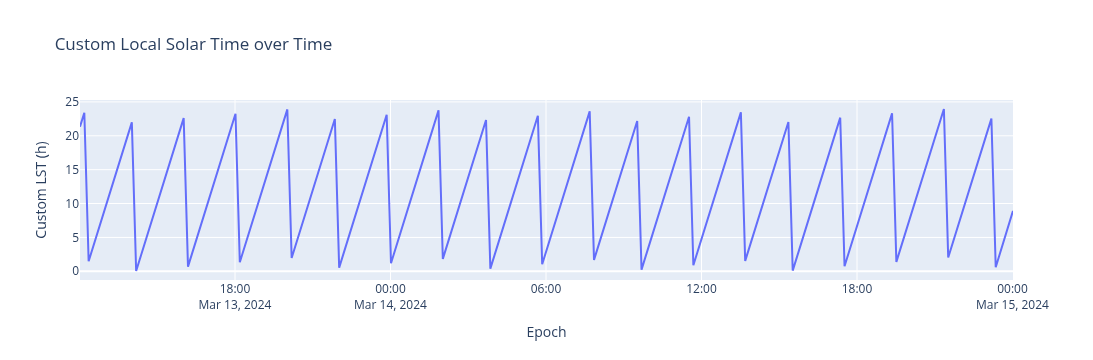

In [4]:
fig = px.line(df, x="Epoch", y="Custom LST (h)", title="Custom Local Solar Time over Time")
fig.show()

## 2. Event Finding

We can search for discrete events such as apoapsis, periapsis, or specific geometric conditions.

In [5]:
lro_frame = Frame(-85, 1)  # LRO NAIF ID
lro_state_spec = analysis.StateSpec(
    target_frame=analysis.FrameSpec.Loaded(lro_frame),
    observer_frame=analysis.FrameSpec.Loaded(Frames.MOON_J2000),
    ab_corr=None,
)

apolune = Event.apoapsis()
perilune = Event.periapsis()

start_epoch, end_epoch = almanac.spk_domain(-85)
# Search over a shorter window
search_end = start_epoch + Unit.Day * 2

print(f"Searching events from {start_epoch} to {search_end}")

apo_events = almanac.report_events(lro_state_spec, apolune, start_epoch, search_end)
print(f"Found {len(apo_events)} apoapsis events.")

peri_events = almanac.report_events(lro_state_spec, perilune, start_epoch, search_end)
print(f"Found {len(peri_events)} periapsis events.")

# Print first few events
for i, event in enumerate(apo_events[:3]):
    print(f"Apoapsis {i+1}: {event.orbit.epoch}")

Searching events from 2023-12-15T00:01:09.183425793 ET to 2023-12-17T00:01:09.183425793 ET
Found 25 apoapsis events.
Found 24 periapsis events.
Apoapsis 1: 2023-12-15T00:07:04.599486254 ET
Apoapsis 2: 2023-12-15T02:05:09.311922236 ET
Apoapsis 3: 2023-12-15T04:03:14.118872647 ET


## 3. Event Arc Finding

Event arcs represent continuous periods where a condition is met, such as being in eclipse or having the sun set.

In [6]:
sun_has_set = analysis.Event(
    analysis.ScalarExpr.SunAngle(observer_id=-85),
    Condition.LessThan(90.0),
    Unit.Second * 0.5,
    ab_corr=None,
)
eclipse = Event.total_eclipse(Frames.MOON_J2000)

sunset_arcs = almanac.report_event_arcs(lro_state_spec, sun_has_set, start_epoch, search_end)
print(f"Found {len(sunset_arcs)} sunset arcs.")

eclipse_arcs = almanac.report_event_arcs(lro_state_spec, eclipse, start_epoch, search_end)
print(f"Found {len(eclipse_arcs)} eclipse arcs.")

if eclipse_arcs:
    print(f"First eclipse duration: {eclipse_arcs[0].duration()}")

Found 11 sunset arcs.
Found 25 eclipse arcs.
First eclipse duration: 39 min 12 s 806 ms 171 μs 252 ns


## 4. Ground Contact Finders

We can simulate ground station visibility by defining locations and masks.

In [7]:
# Define a ground station (DSS65)
mask = [TerrainMask(0.0, 5.0), TerrainMask(35.0, 10.0), TerrainMask(270.0, 3.0)]
dss65 = Location(
    40.427_222,
    4.250_556,
    0.834_939,
    FrameUid(399, 399),
    mask,
    terrain_mask_ignored=True,
)

# Create and save an LKA (Location Kernel Anise) file
entry = LocationDhallSetEntry(dss65, id=1, alias="DSS65")
dhallset = LocationDhallSet([entry])
dataset = dhallset.to_dataset()
lka_path = "tutorial_loc_kernel.lka"
dataset.save_as(lka_path, True)

# Load the LKA into the Almanac
almanac = almanac.load(lka_path)

# Find visibility arcs
horizon = Event.visible_from_location_id(1)

comm_arcs = almanac.report_event_arcs(
    lro_state_spec, horizon, start_epoch, start_epoch + Unit.Day * 1
)
print(f"Found {len(comm_arcs)} Comm arcs (1 day).")

# More detailed visibility report
visibility_arcs = almanac.report_visibility_arcs(
    lro_state_spec, 1, start_epoch, start_epoch + Unit.Day * 1, Unit.Minute * 10, None
)

if visibility_arcs:
    first_pass = visibility_arcs[0]
    print(f"First pass duration: {first_pass.duration()}")
    print(f"Pass location: {first_pass.location_ref}")
    
    # Access AER (Azimuth, Elevation, Range) data
    print(f"Number of AER data points: {len(first_pass.aer_data)}")
else:
    print("No visibility arcs found.")

[save_as] overwriting tutorial_loc_kernel.lka


Found 1 Comm arcs (1 day).
First pass duration: 8 h 56 min 55 s 251 ms 300 μs 749 ns
Pass location: DSS65 (#1)
Number of AER data points: 54
